<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/bonespect_train_0828.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from glob import glob
import numpy as np
import cv2, os, copy, shutil
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim



In [2]:
inputNpyList = sorted(glob("/content/drive/MyDrive/Bone_SPECT/inputData/*.npy"))
labelNpyList = sorted(glob("/content/drive/MyDrive/Bone_SPECT/labelData/*.npy"))

In [3]:
inputNpyList[0]

'/content/drive/MyDrive/Bone_SPECT/inputData/23060101_input.npy'

In [4]:
testImg = np.load(inputNpyList[0])

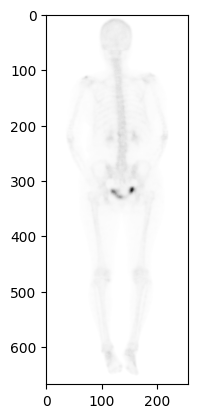

In [5]:
plt.imshow(testImg, cmap='gray_r')
plt.show()

In [6]:
for i in range(238):
    tempInput = inputNpyList[i].split("/")[-1][-18:-10]
    tempLabel = labelNpyList[i].split("/")[-1][-18:-10]
    if tempInput != tempLabel:
        print(i)
    else:
        continue

In [7]:
inputObj = []
labelObj = []
sizesImg = []

for i in range(238):
    tempInputObj = np.load(inputNpyList[i])
    tempInputObj = np.array(tempInputObj, dtype=np.uint16)
    tempLabelObj = np.load(labelNpyList[i])
    tempLabelObj = np.array(tempLabelObj, dtype=np.uint16)
    sizesImg.append(np.shape(tempInputObj)[0])
    inputObj.append(tempInputObj)
    labelObj.append(tempLabelObj)

In [8]:
MAX_SIZE = 1024

In [9]:
train_imgs = []
train_lbls = []

In [10]:
for i in range(238):
    io_x, ioy = np.shape(inputObj[i])
    if io_x != MAX_SIZE:
        diffIOx = MAX_SIZE - io_x
        zeroPadding = np.zeros((diffIOx,256))
        tempInput = np.vstack([inputObj[i],zeroPadding])
        tempLabel = np.vstack([labelObj[i],zeroPadding])
        train_imgs.append(tempInput)
        train_lbls.append(tempLabel)
    else:
        train_imgs.append(inputObj[i])
        train_lbls.append(labelObj[i])

In [11]:
temp_train_imgs = np.array(train_imgs)
temp_train_lbls = np.array(train_lbls)

In [12]:
temp_train_lbls[temp_train_lbls >=1] = 1

In [13]:
split_num = 200

In [14]:
train_imgs = temp_train_imgs[:split_num,...]
valid_imgs = temp_train_imgs[split_num:,...]
train_msks = temp_train_lbls[:split_num,...]
valid_msks = temp_train_lbls[split_num:,...]

In [15]:
train_imgs = np.array(train_imgs, dtype=np.float32)
train_msks = np.array(train_msks, dtype=np.float32)
valid_imgs = np.array(valid_imgs, dtype=np.float32)
valid_msks = np.array(valid_msks, dtype=np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

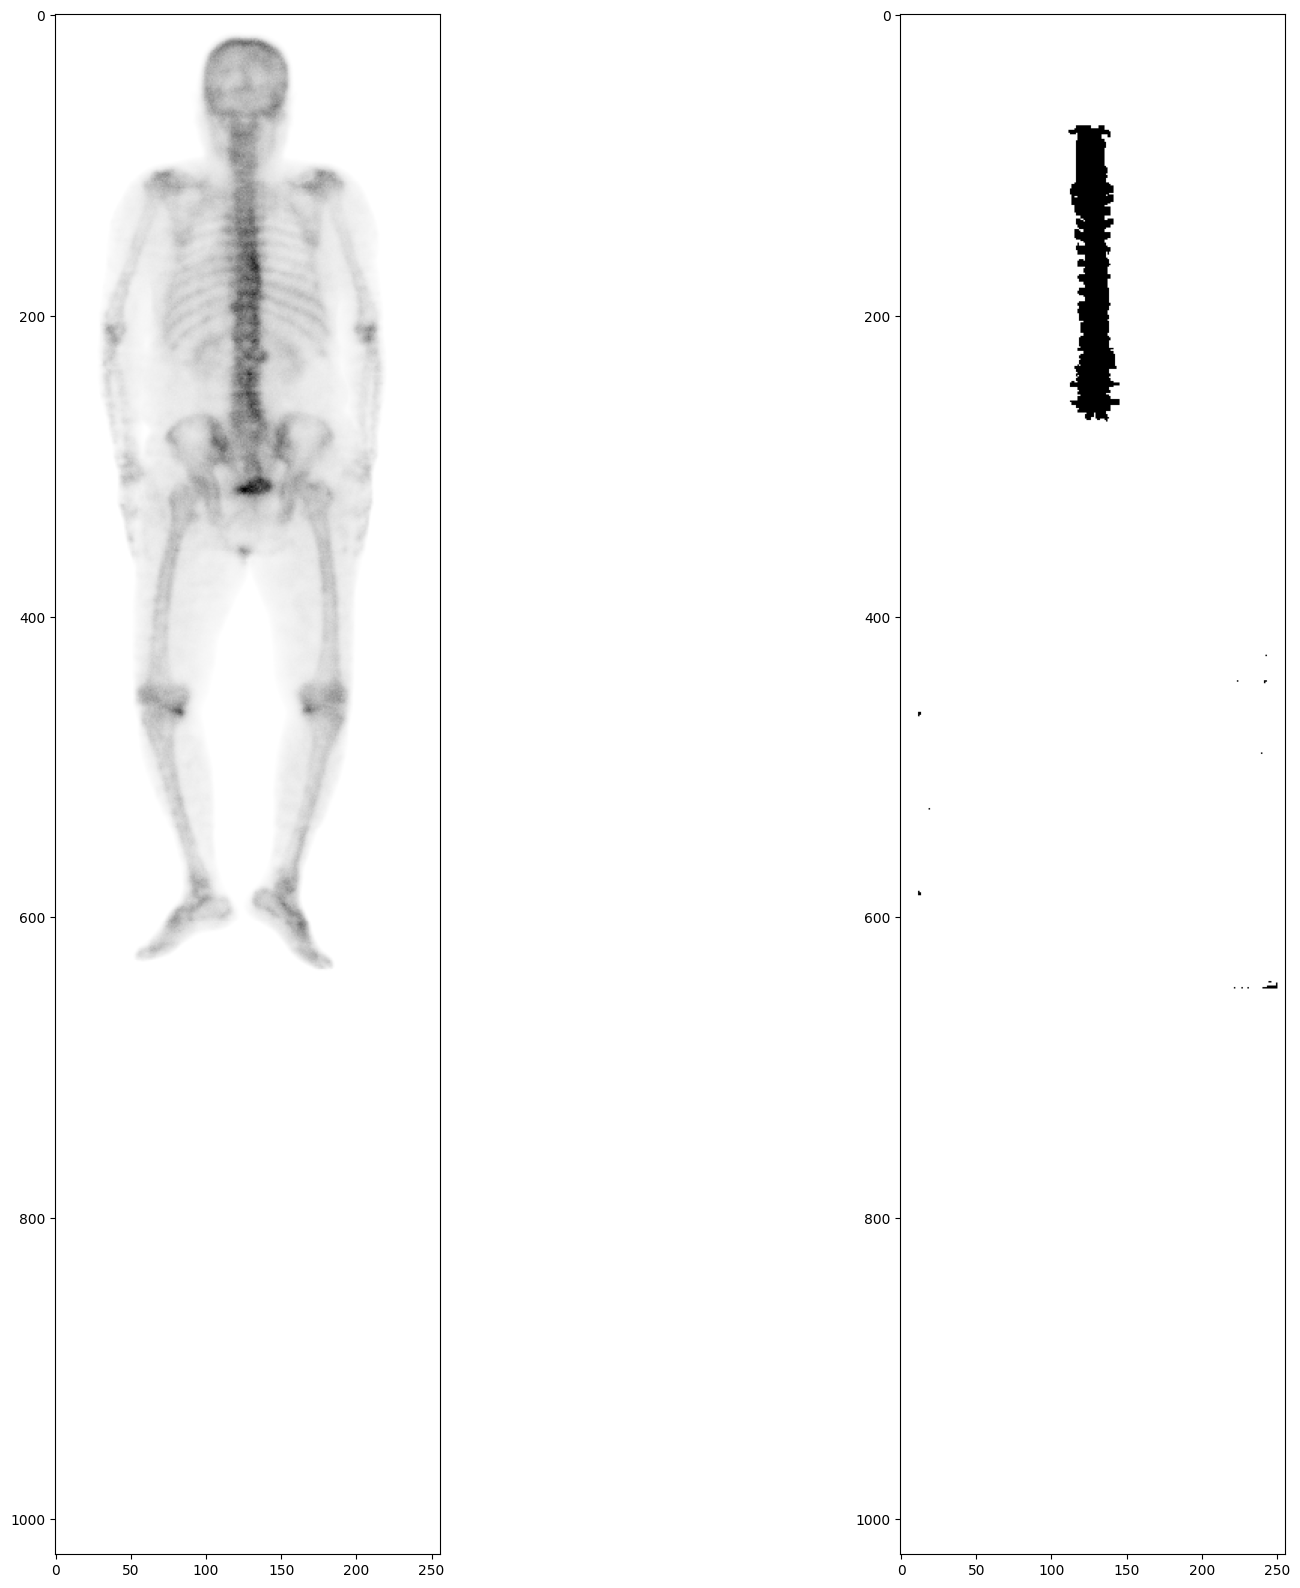

In [16]:
%matplotlib inline

rand_num = randint(1,len(train_imgs))

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num], cmap='gray_r')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[rand_num]), cmap='gray_r')

In [17]:
test_img = train_imgs[10] * np.squeeze(train_msks[10])

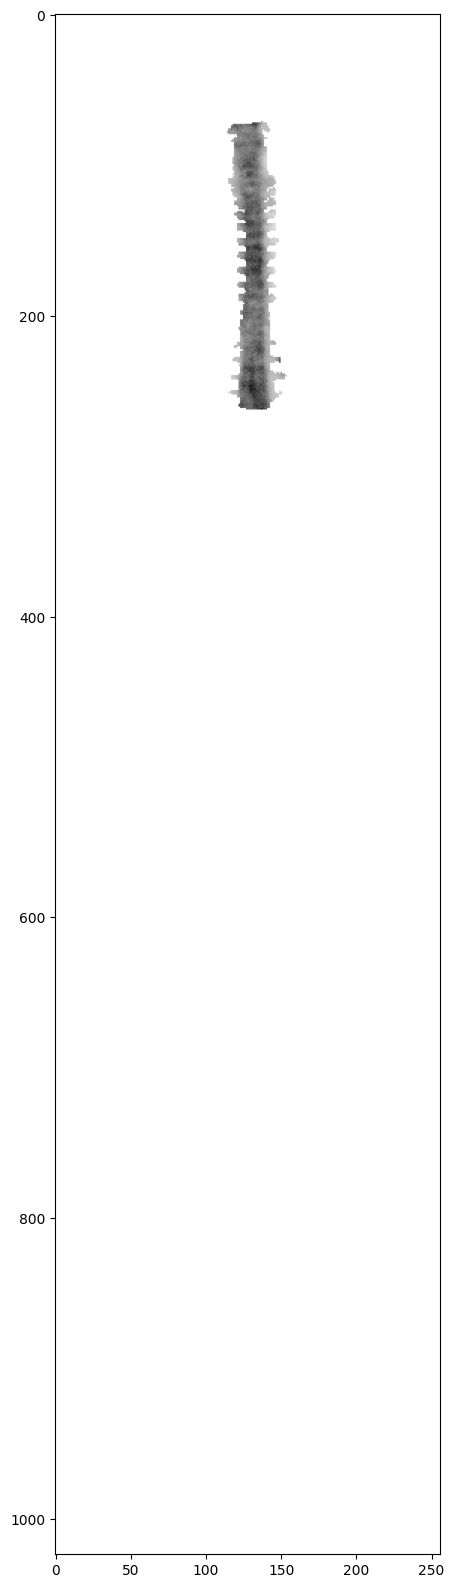

In [18]:
plt.figure(0, figsize=(20, 20))
plt.imshow(test_img, cmap="gray_r")
plt.show()

In [19]:
inputs = Input((MAX_SIZE, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [20]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

In [21]:
initial_learning_rate = 5e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Bone_SPECT/models/mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [22]:
model.compile(Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [23]:
model.fit(train_imgs, train_msks, batch_size=10, epochs=200, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.8321 - binary_crossentropy: 0.7006 - generalized_dice_coefficient: 0.0364
Epoch 1: val_loss improved from inf to 0.83213, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_1.h5
20/20 [==============================] - 21s 336ms/step - loss: 0.8321 - binary_crossentropy: 0.7006 - generalized_dice_coefficient: 0.0364 - val_loss: 0.8321 - val_binary_crossentropy: 0.7031 - val_generalized_dice_coefficient: 0.0390
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.8306 - binary_crossentropy: 0.6971 - generalized_dice_coefficient: 0.0358
Epoch 2: val_loss improved from 0.83213 to 0.82950, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_2.h5
20/20 [==============================] - 4s 226ms/step - loss: 0.8306 - binary_crossentropy: 0.6971 - generalized_dice_coefficient: 0.0358 - val_loss: 0.8295 - val_binary_crossentropy: 0.6960 - val_generalized_dice_coefficient: 0.0371

In [24]:
np.shape(train_imgs[0])

(1024, 256)

In [25]:
prediction = np.array([train_imgs[0]])

In [26]:
pred_img = model.predict(prediction)

1/1 [==============================] - 1s 769ms/step


In [27]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [28]:
pltImg = np.squeeze(pred_img)

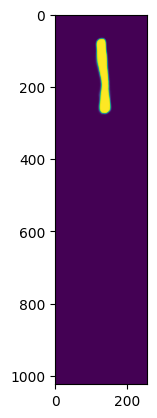

In [29]:
plt.imshow(pltImg)
plt.show()

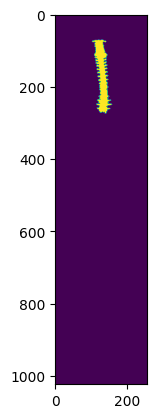

In [30]:
plt.imshow(train_msks[0])
plt.show()

In [ ]:
srcPath = "/content/drive/MyDrive/Bone_SPECT/upload.zip"
dstPath = "/content/drive/MyDrive/Bone_SPECT"

import zipfile

with zipfile.ZipFile(srcPath, 'r') as zip_ref:
    zip_ref.extractall(dstPath)